# Applying TemporalFusionTransformer for load forecast 

**modified versions**
1. 实现

In [1]:
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import copy
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAPE, RMSE, MAE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## load data

In [3]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')
data.index = pd.to_datetime(data.index)

data['group'] = 0
data['time_idx'] = np.arange(data.shape[0])
# add group and time_idx

# data['wea'] = data.wea.astype('str').astype('category')
data['dir'] = data.dir.astype('str').astype('category')
data['winclass'] = data.winclass.astype('str').astype('category')
# data['year'] = data.year.astype('str').astype('category')
data['month'] = data.month.astype('str').astype('category')
data['day_of_week'] = data.day_of_week.astype('str').astype('category')
data['is_workday'] = data.is_workday.astype('str').astype('category')
# categories to be str

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31659 entries, 2017-01-01 00:00:00 to 2020-08-16 23:00:00
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   wea           31659 non-null  float64 
 1   tem           31659 non-null  float64 
 2   hum           31659 non-null  float64 
 3   win           31659 non-null  float64 
 4   dir           31659 non-null  category
 5   winclass      31659 non-null  category
 6   tembody       31659 non-null  float64 
 7   year          31659 non-null  int64   
 8   month         31659 non-null  category
 9   day           31659 non-null  int64   
 10  hour          31659 non-null  int64   
 11  day_of_year   31659 non-null  int64   
 12  week_of_year  31659 non-null  int64   
 13  day_of_week   31659 non-null  category
 14  is_workday    31659 non-null  category
 15  load          31659 non-null  float64 
 16  group         31659 non-null  int64   
 17  time_idx      3

## create dataset and dataloaders

In [5]:
max_prediction_length = 24
max_encoder_length = 72
training_cutoff = data["time_idx"].max() * 0.8

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],  # ***这是？***
    time_idx="time_idx",
    target="load",
    group_ids=["group"],
    min_encoder_length=max_encoder_length //
    2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    #     min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=[
        "dir", "winclass", "month", "day_of_week", "is_workday"
    ],
    time_varying_known_reals=[
        "wea", "tem", "hum", "win", "tembody", "year", "day", "hour",
        "day_of_year", "week_of_year"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "load",
    ],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True)

# create dataloaders for model
batch_size = 256
train_dataloader = training.to_dataloader(train=True,
                                          batch_size=batch_size,
                                          num_workers=0)
val_dataloader = validation.to_dataloader(train=False,
                                          batch_size=batch_size,
                                          num_workers=0)

## define trainer with early stop

In [202]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4,
                                    patience=1,
                                    verbose=False,
                                    mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## create the model

In [6]:
tft = TemporalFusionTransformer.from_dataset(training,
                                             learning_rate=0.03,
                                             hidden_size=16,
                                             attention_head_size=1,
                                             dropout=0.1,
                                             hidden_continuous_size=8,
                                             output_size=7,
                                             loss=QuantileLoss(),
                                             log_interval=2,
                                             reduce_on_plateau_patience=4)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 34.7k


## find optimal learning rate

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /home/mark/jupyter_notebook_files/20211220-point-forecast/1223-code-DL/lr_find_temp_model_ae205402-c7c5-4f9b-8aac-da4d0f8efbc4.ckpt


suggested learning rate: 0.03548133892335756


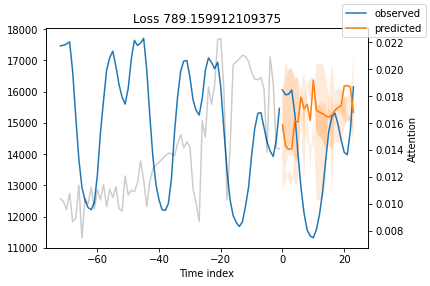

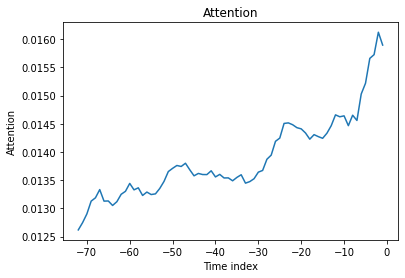

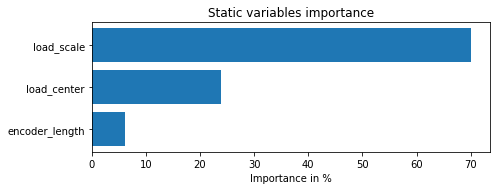

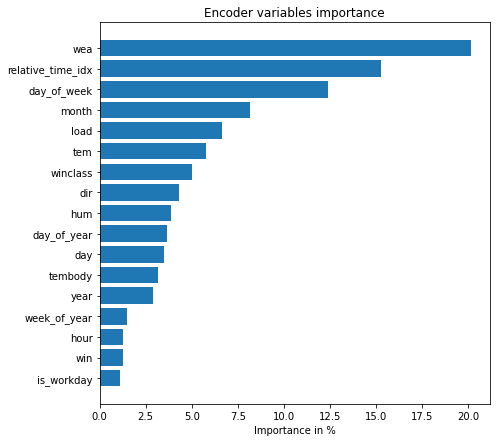

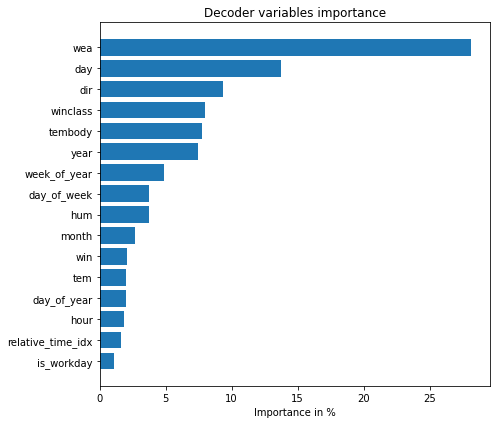

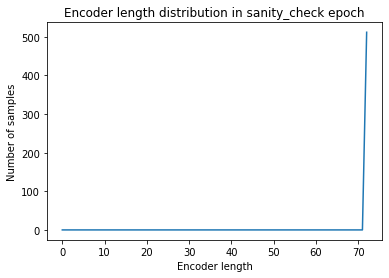

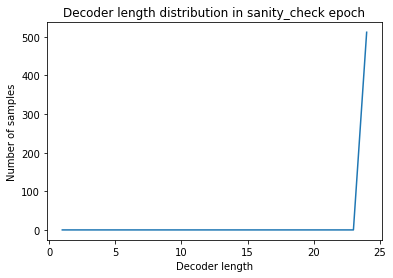

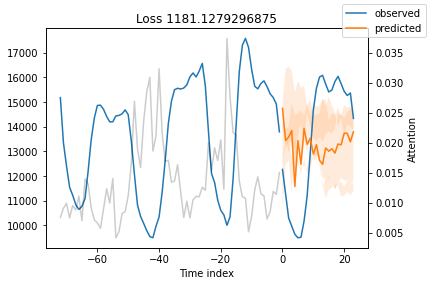

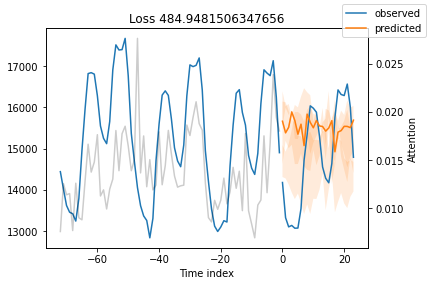

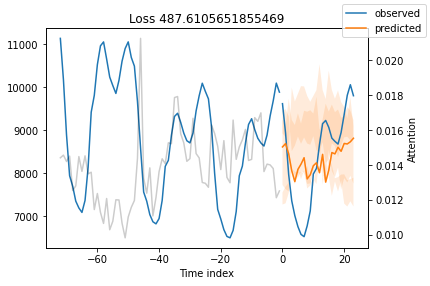

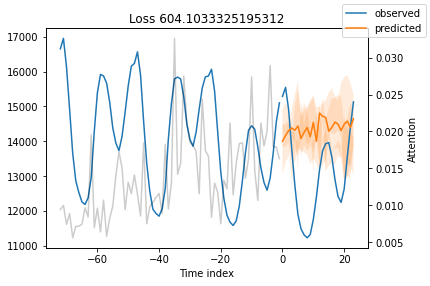

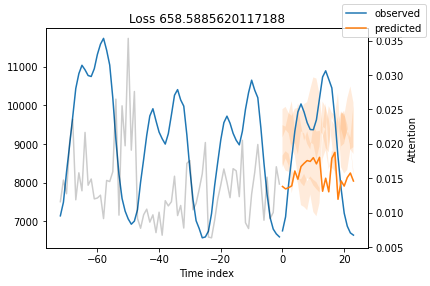

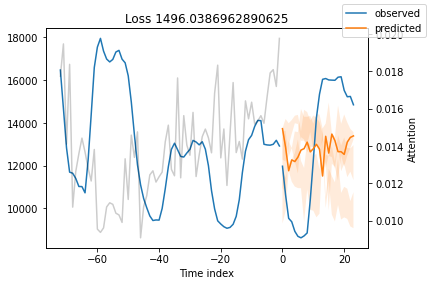

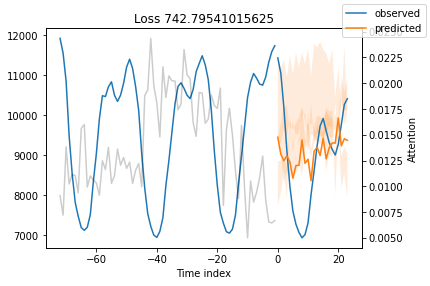

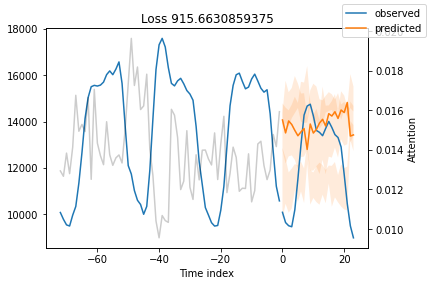

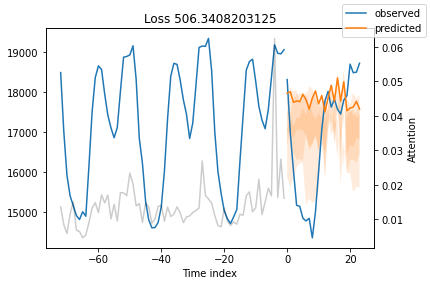

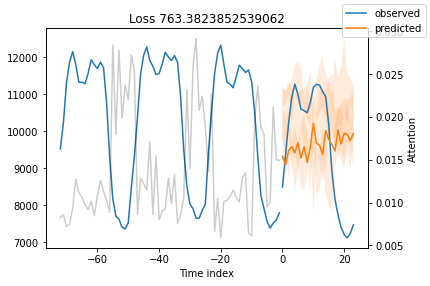

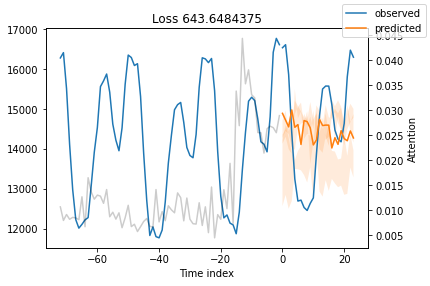

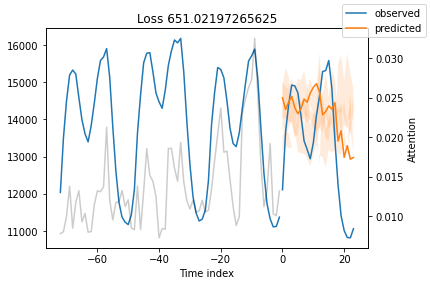

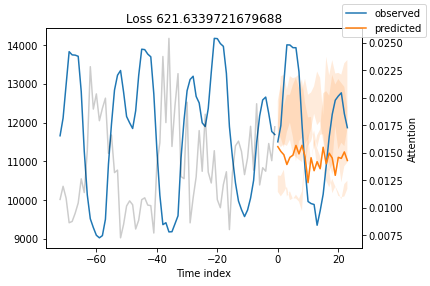

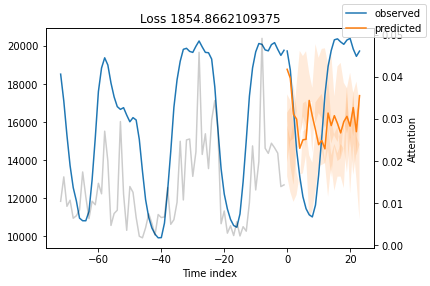

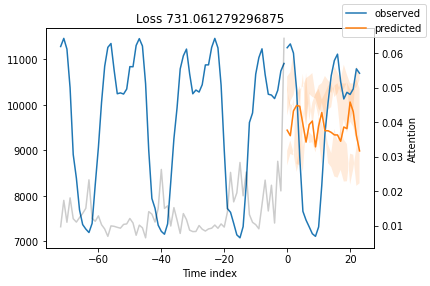

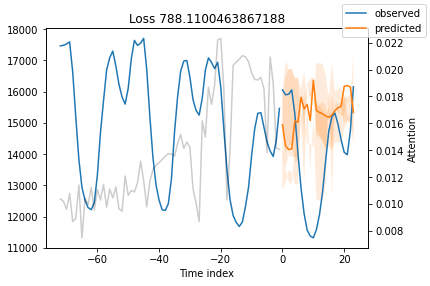

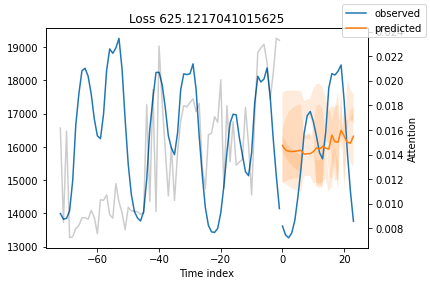

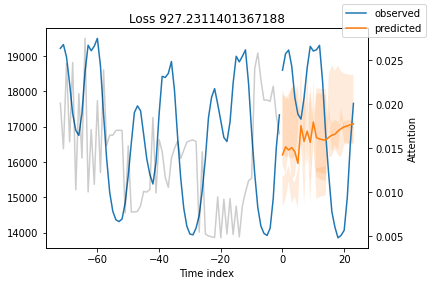

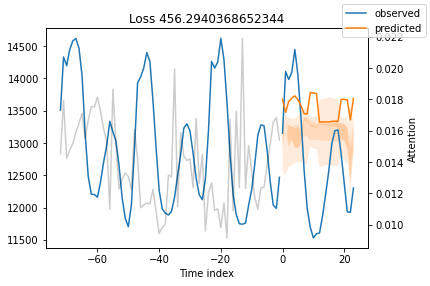

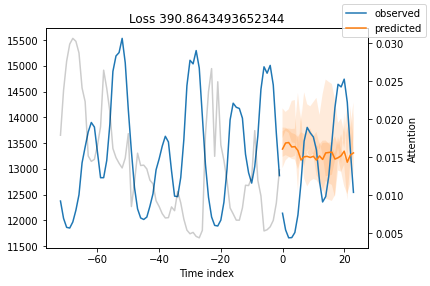

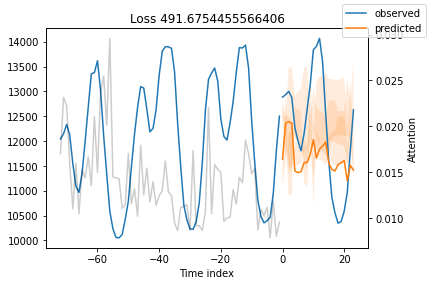

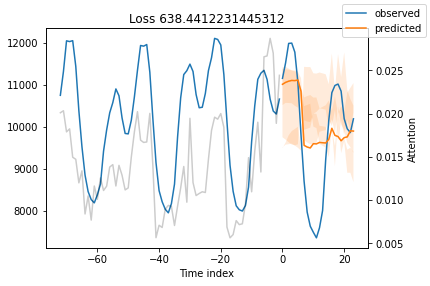

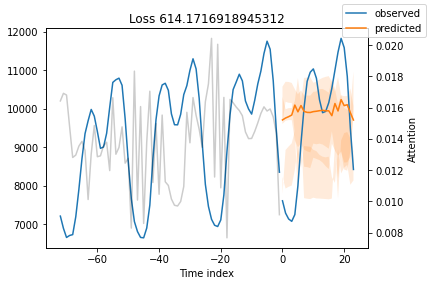

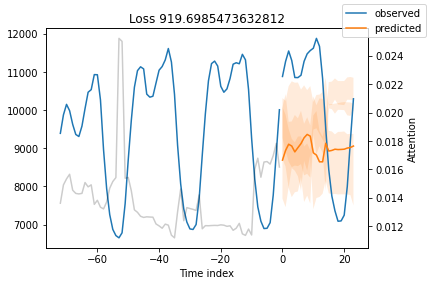

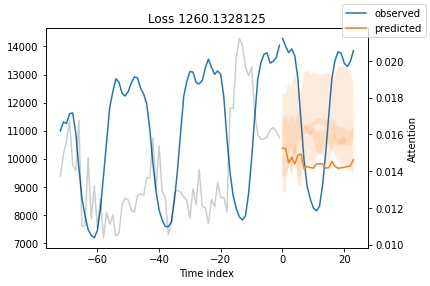

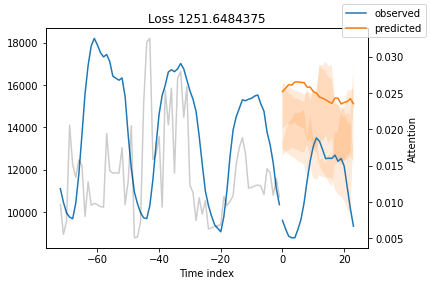

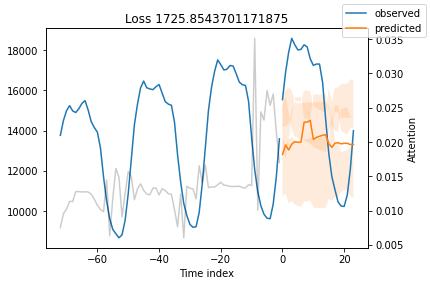

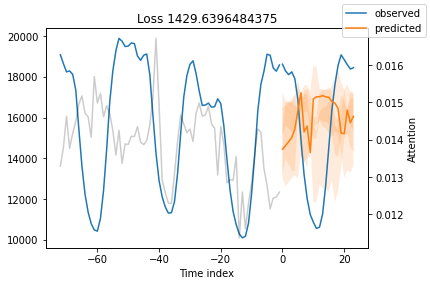

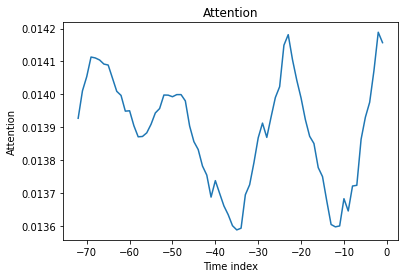

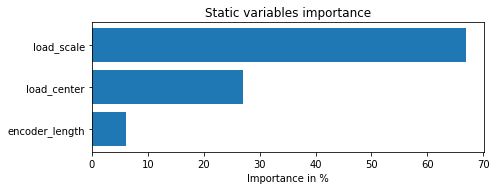

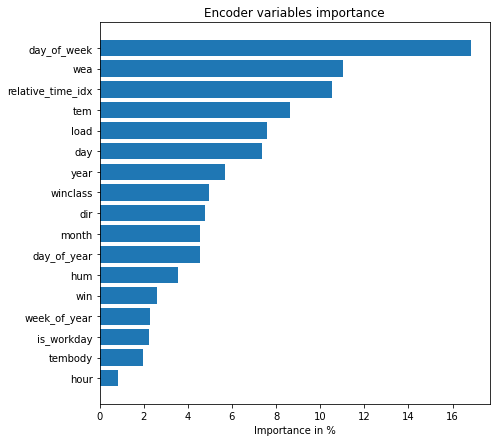

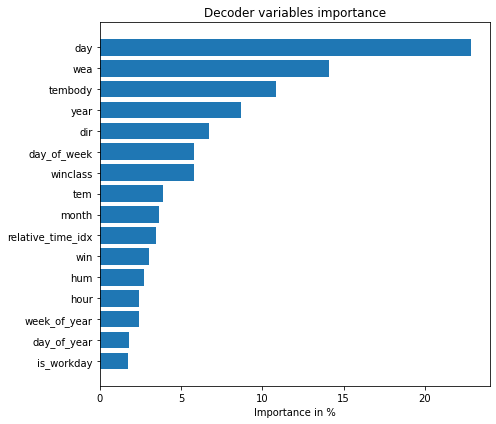

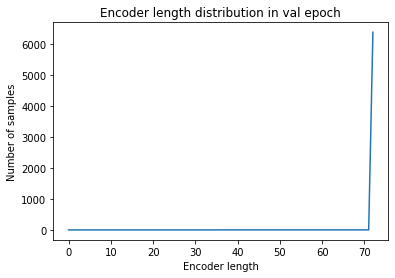

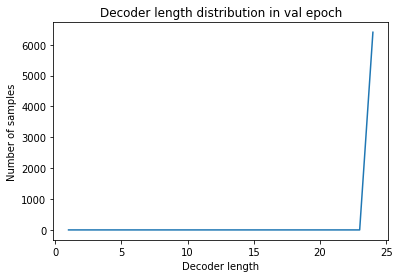

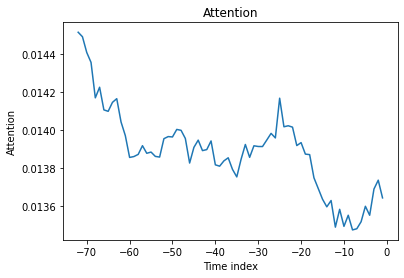

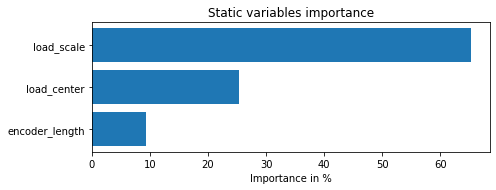

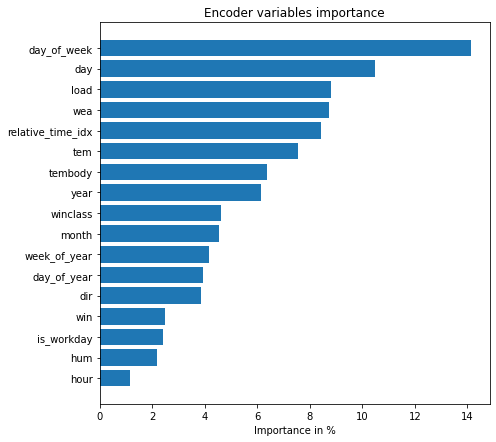

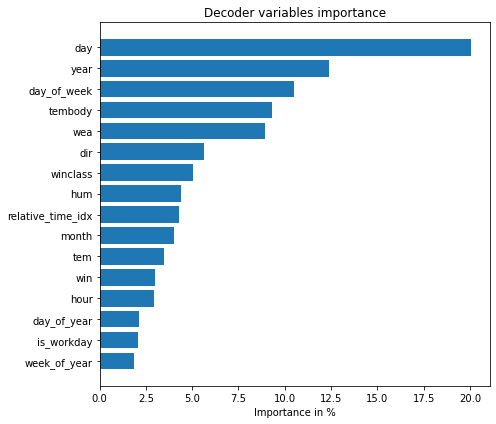

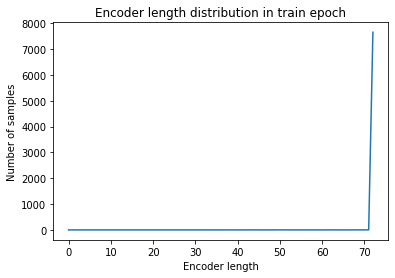

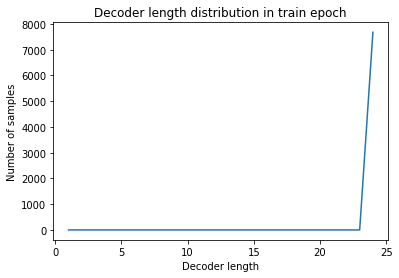

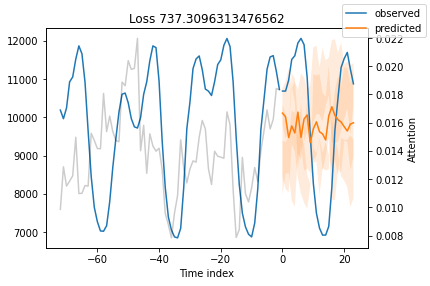

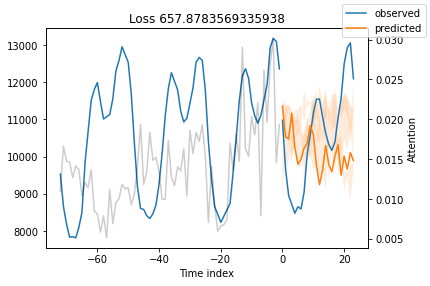

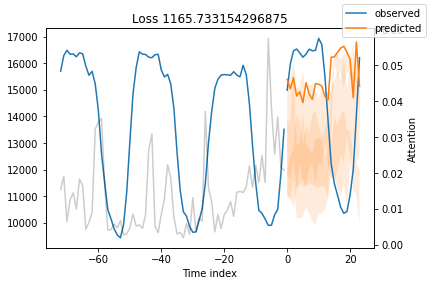

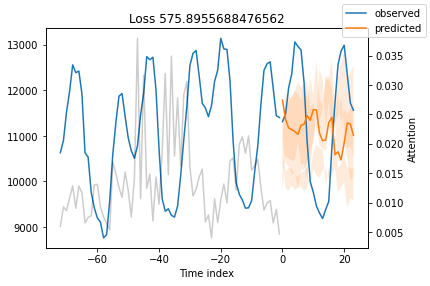

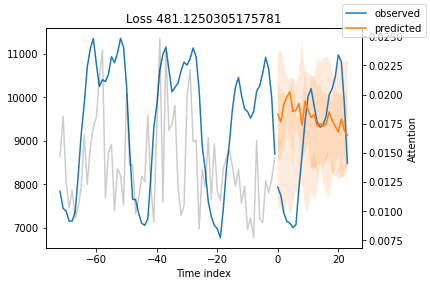

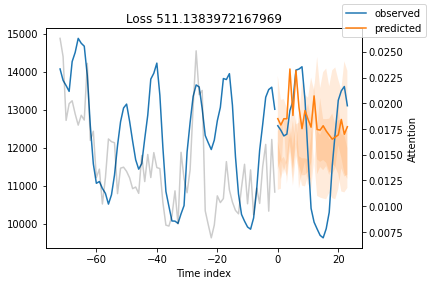

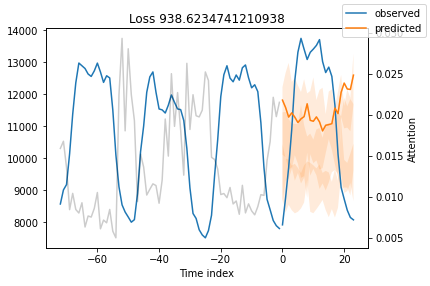

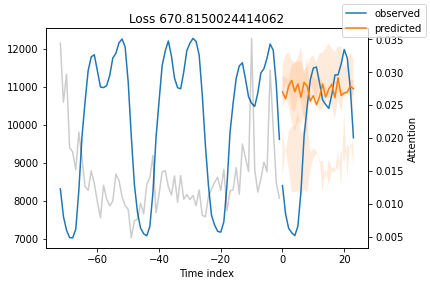

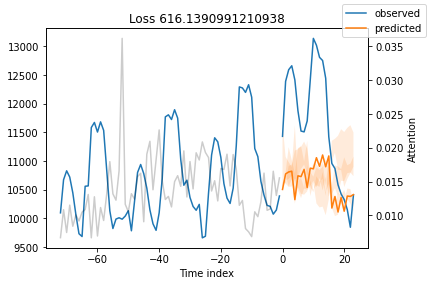

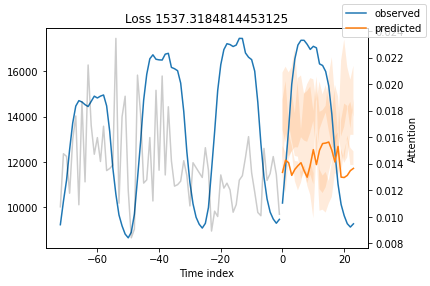

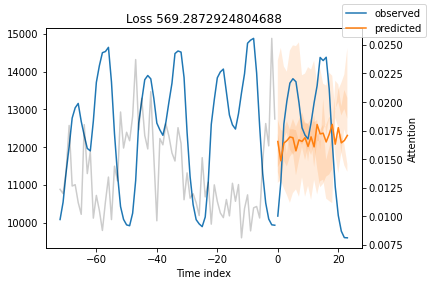

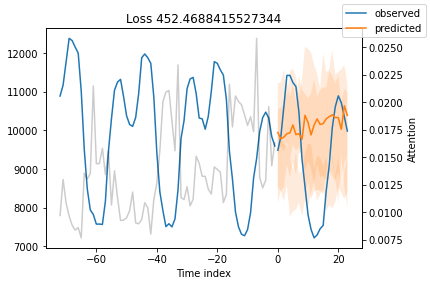

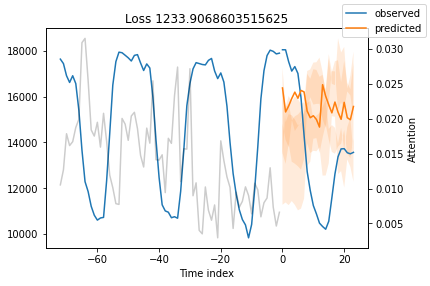

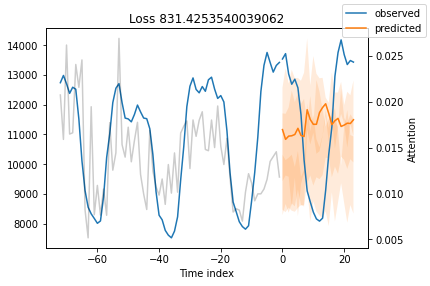

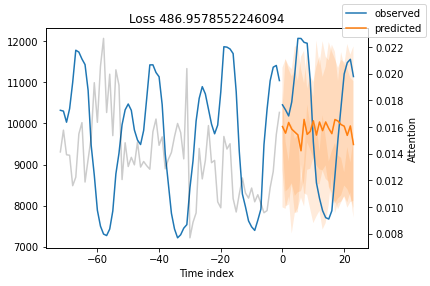

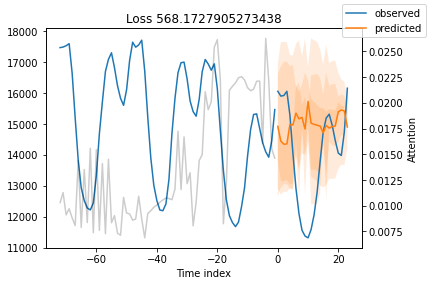

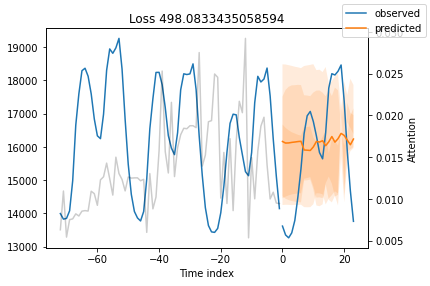

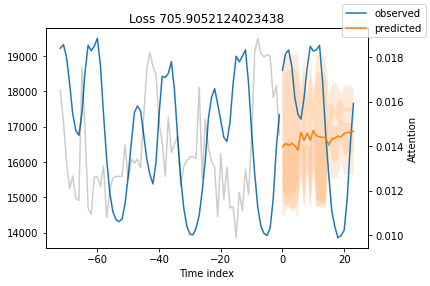

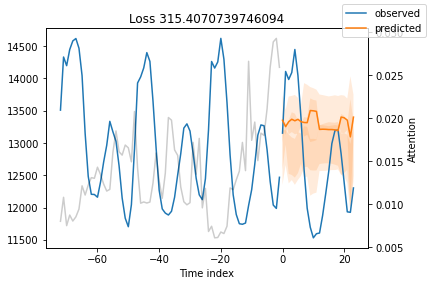

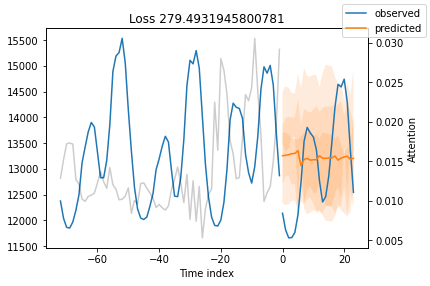

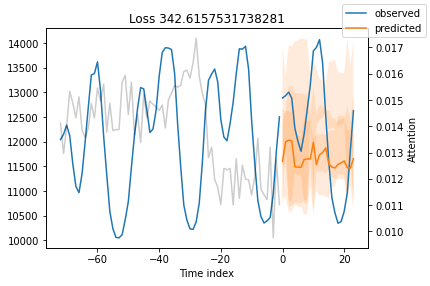

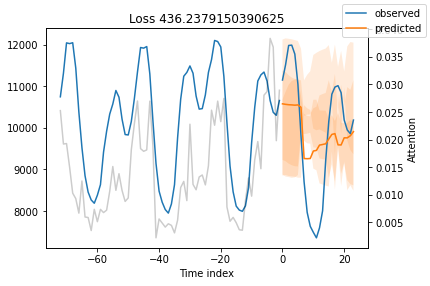

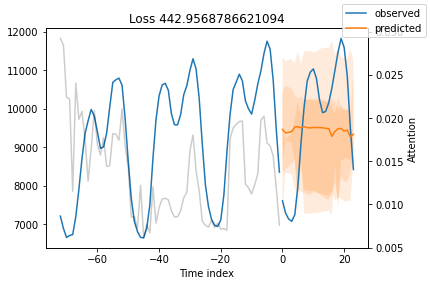

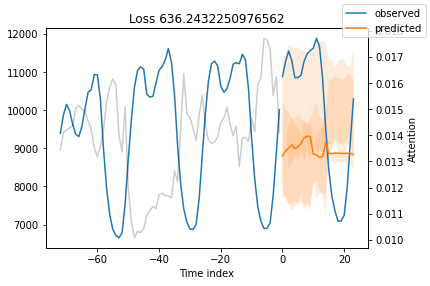

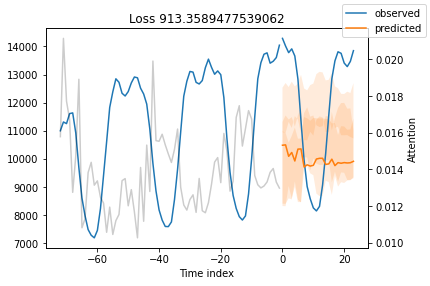

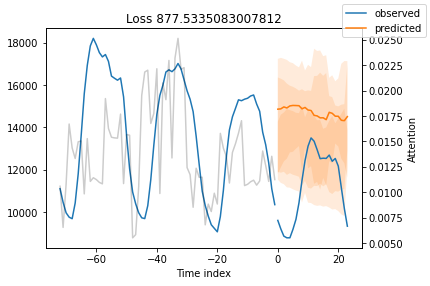

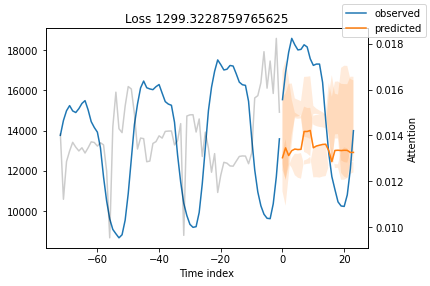

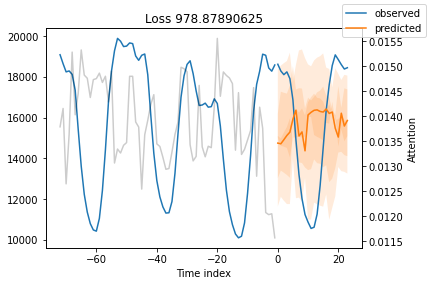

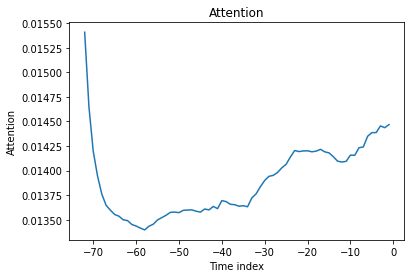

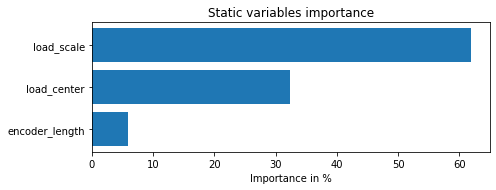

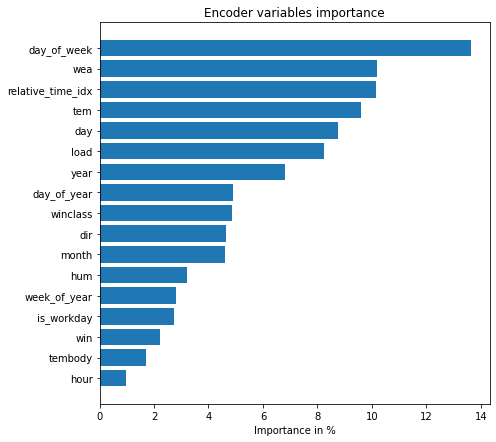

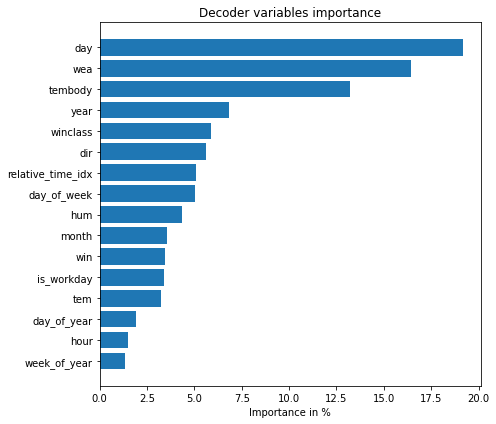

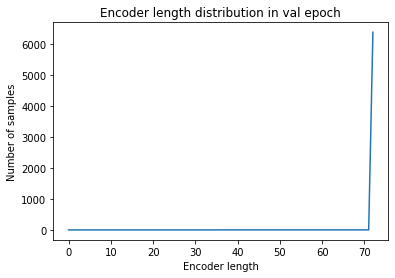

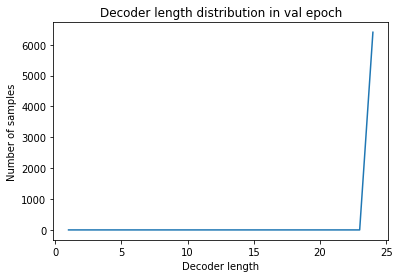

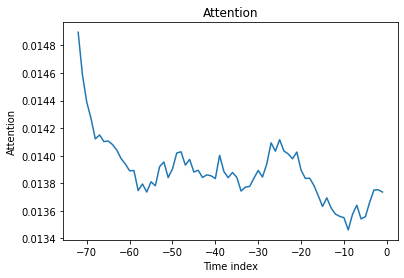

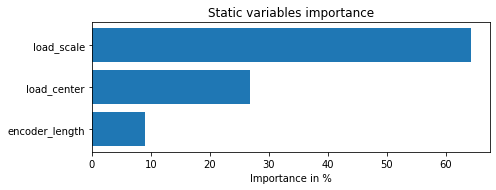

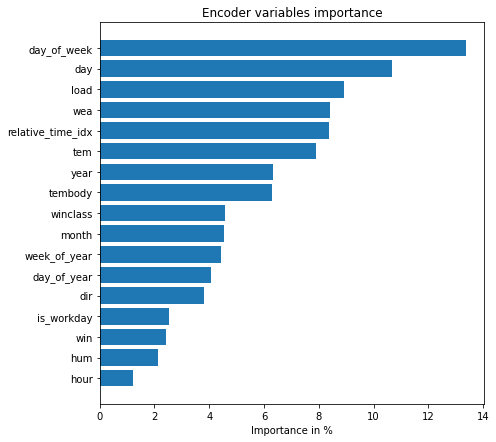

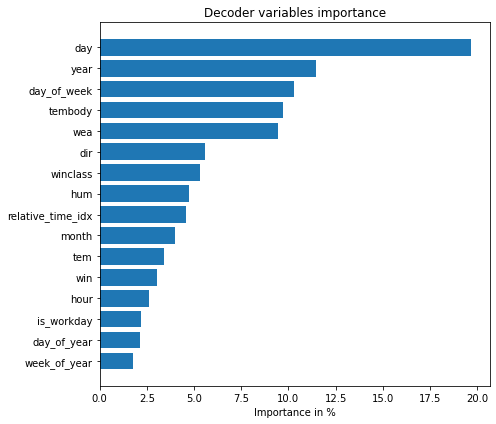

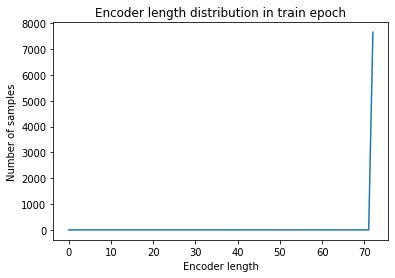

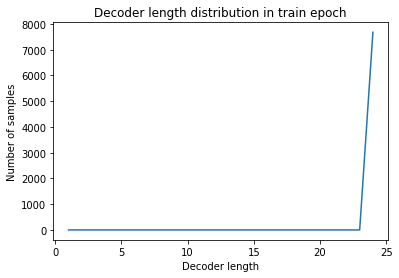

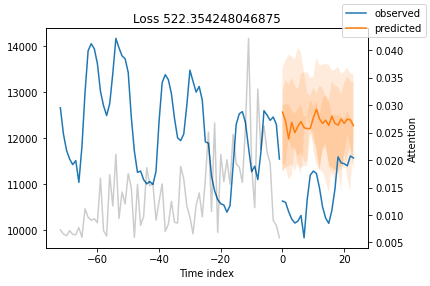

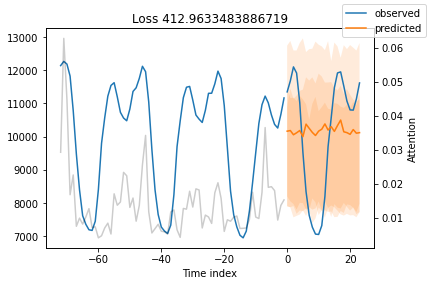

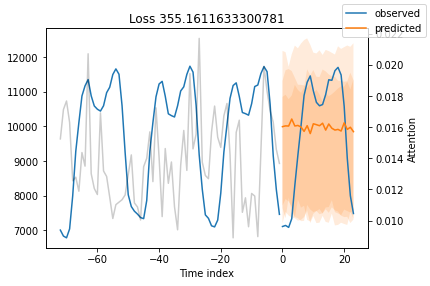

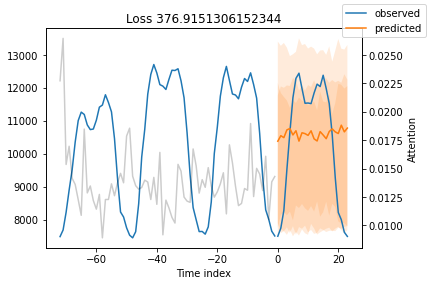

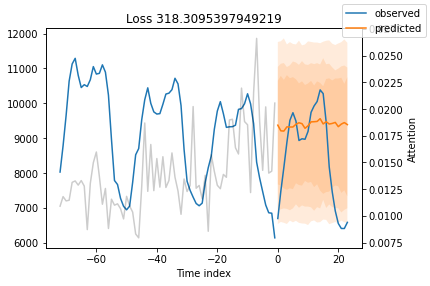

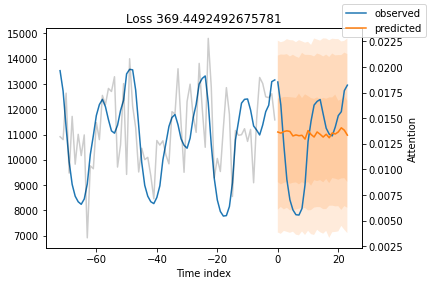

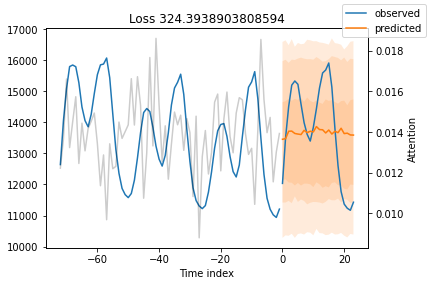

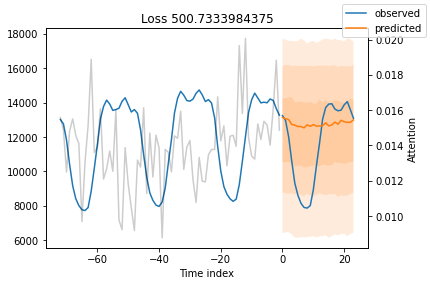

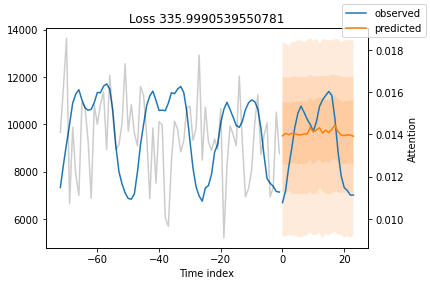

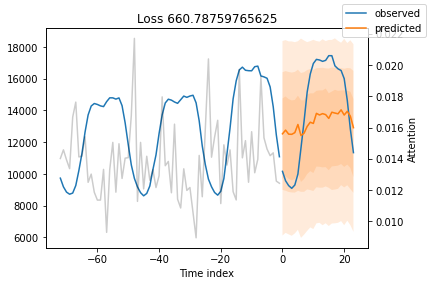

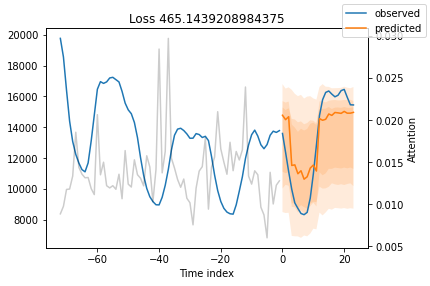

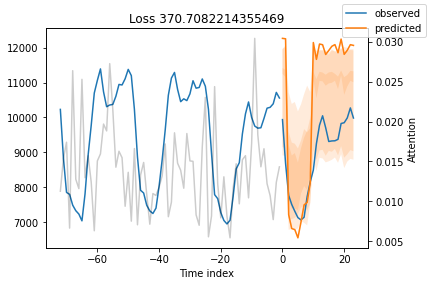

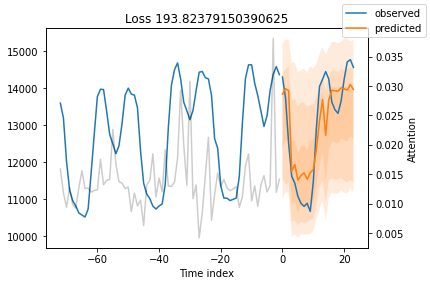

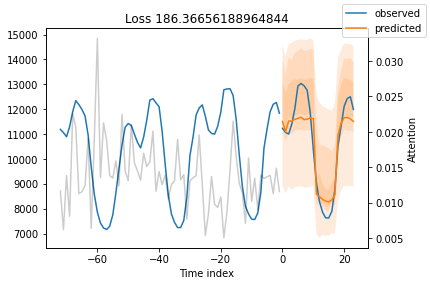

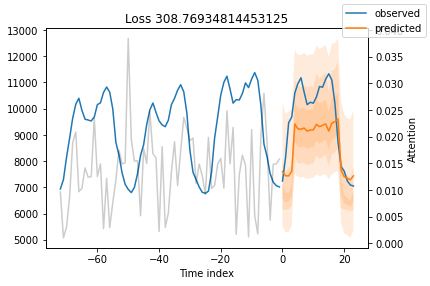

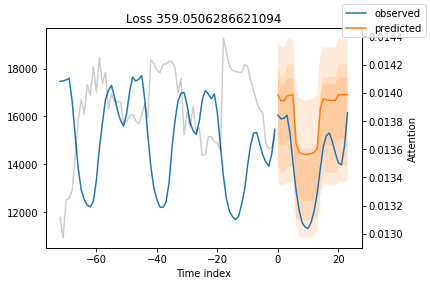

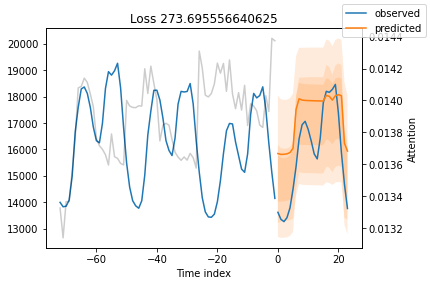

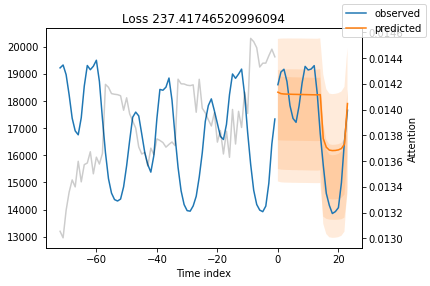

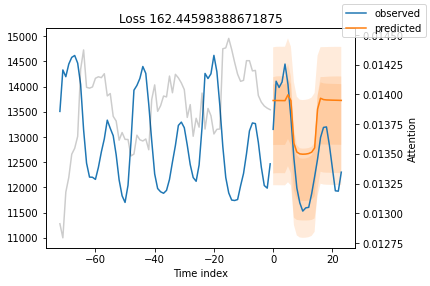

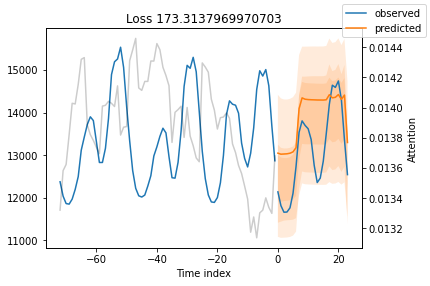

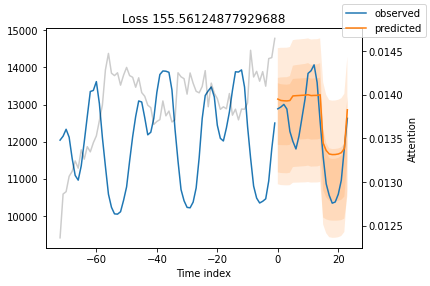

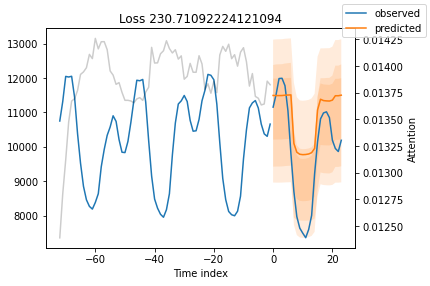

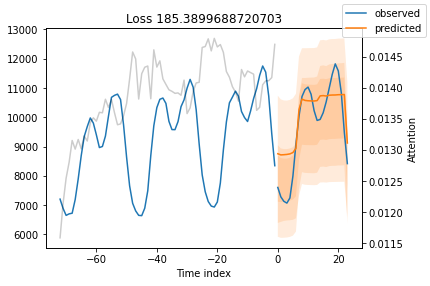

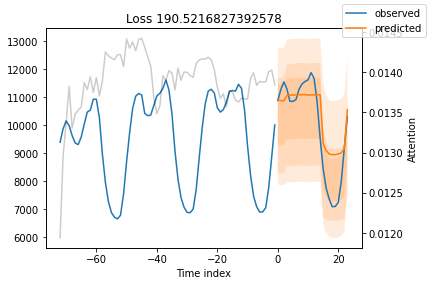

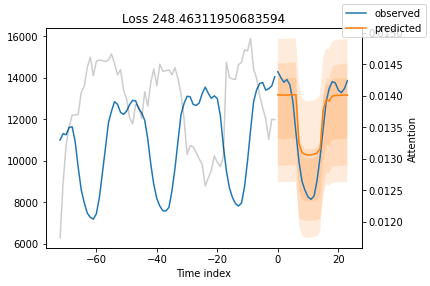

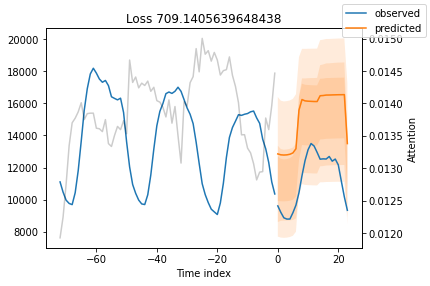

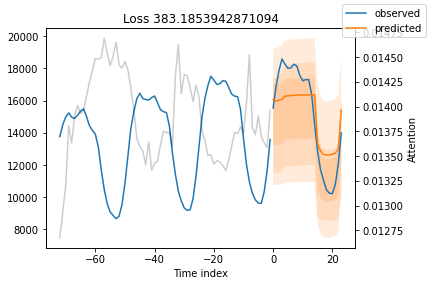

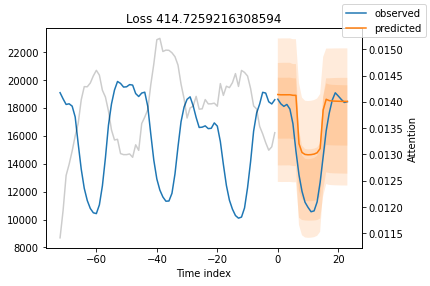

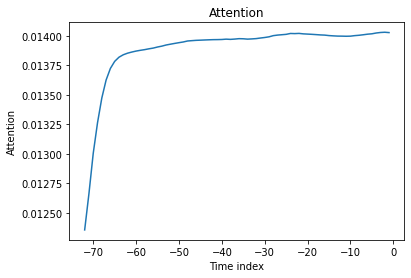

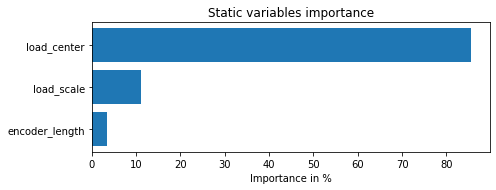

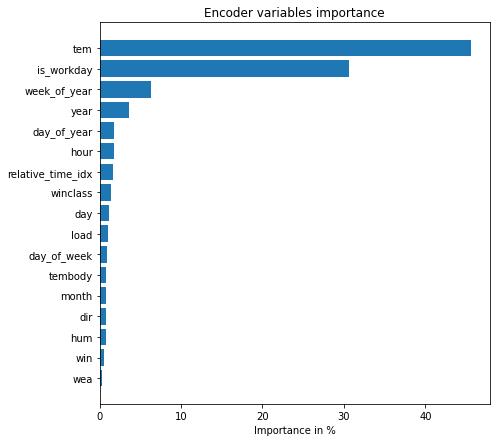

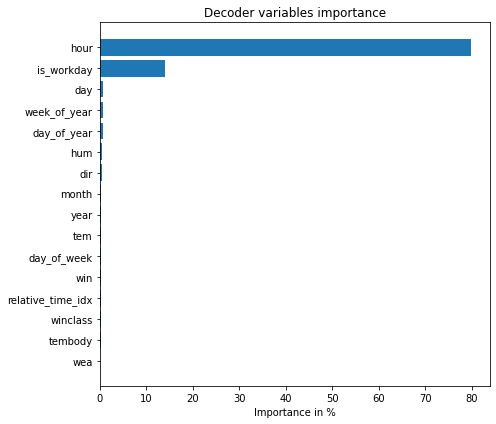

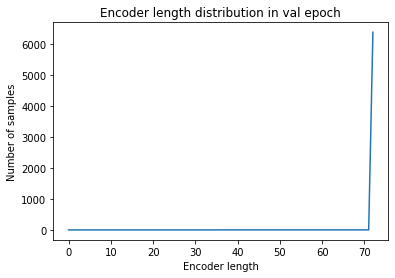

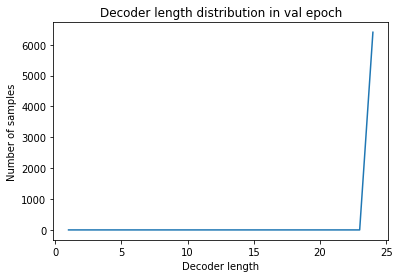

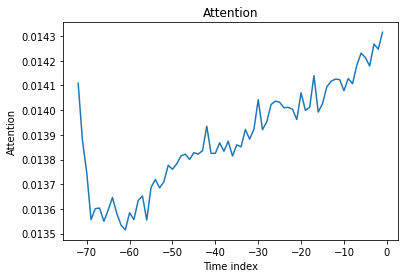

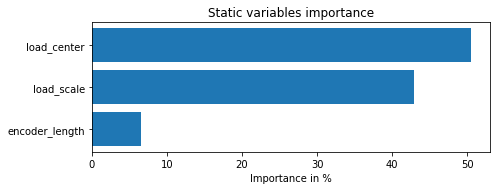

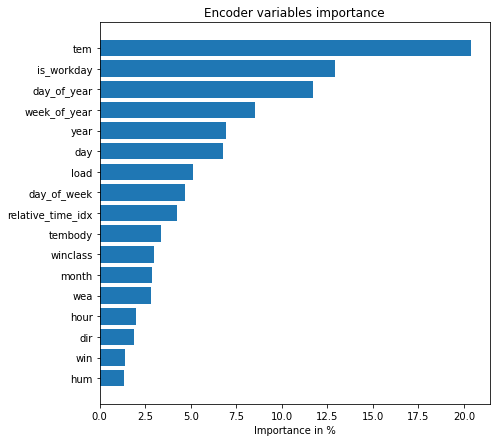

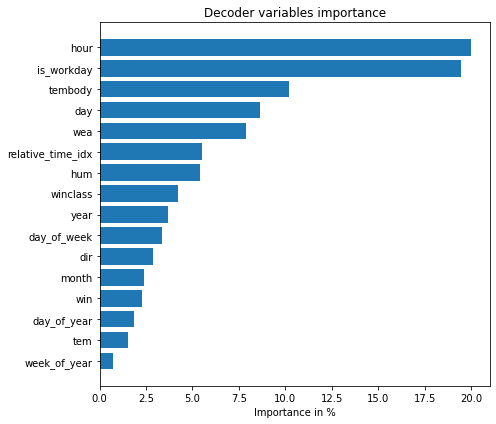

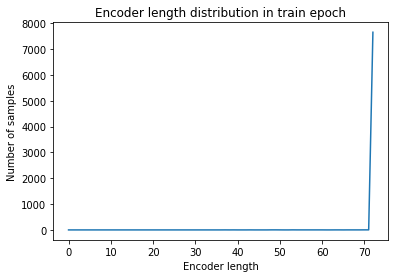

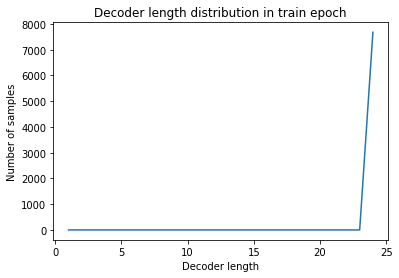

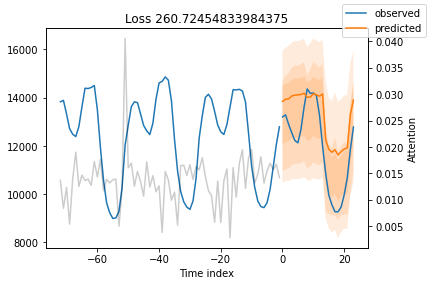

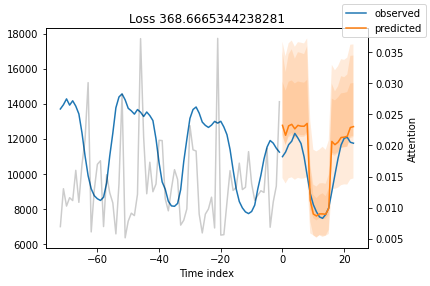

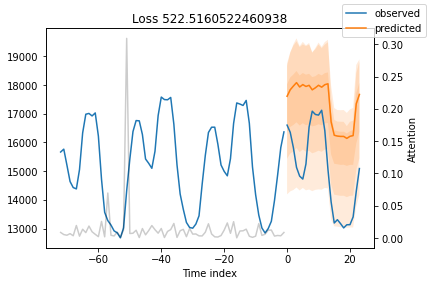

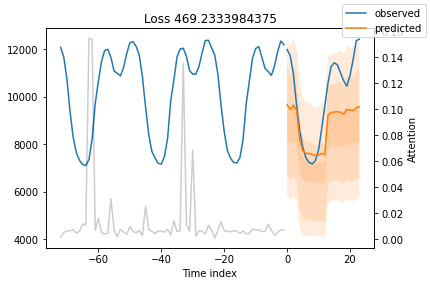

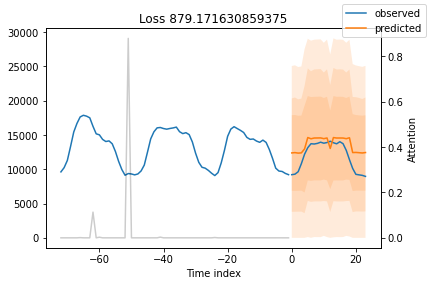

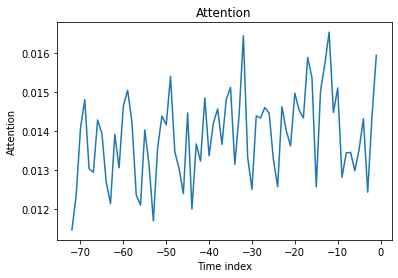

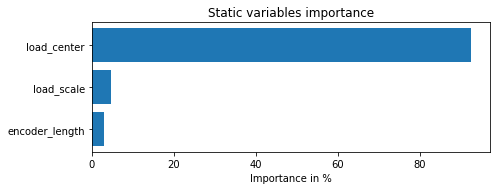

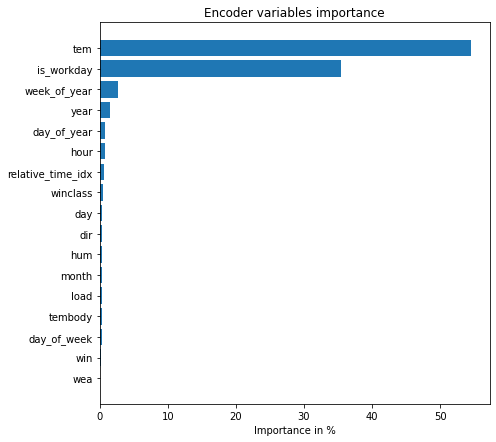

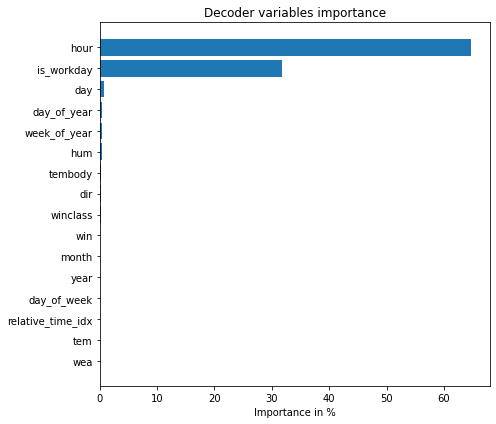

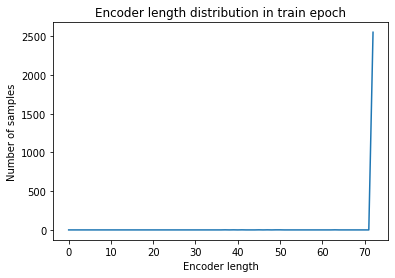

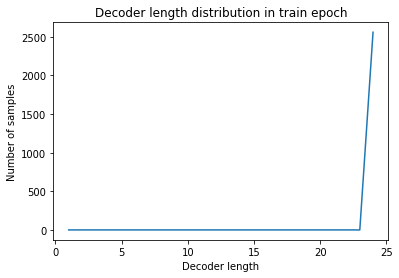

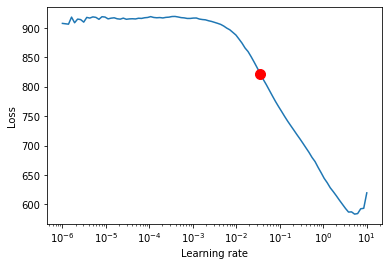

In [203]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Hyper-parameter tuning

In [231]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=20,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 32),
    hidden_continuous_size_range=(8, 16),
    attention_head_size_range=(1, 4),
    learning_rate=0.035,
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=
    False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-01-07 16:20:54,778] A new study created in memory with name: no-name-b8a59291-9181-415f-acec-9ac8cbaf8246
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
[I 2022-01-07 16:38:14,626] Trial 0 finished with value: 117.04674530029297 and parameters: {'gradient_clip_val': 0.3562583617088899, 'hidden_size': 18, 'dropout': 0.2973416333554103, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.001767185589096251}. Best is trial 0 with value: 117.04674530029297.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Global seed set to 42
[I 2022-01-07 16:55:45,294] Trial 1 finished with value: 133.72076416015625 and parameters: {'gradient_clip_val': 0.10959064224503913, 'hidden_size': 29, 'dropout': 0.2655965950751067, 'hidden_continuous_size': 1

{'gradient_clip_val': 0.3562583617088899, 'hidden_size': 18, 'dropout': 0.2973416333554103, 'hidden_continuous_size': 11, 'attention_head_size': 1, 'learning_rate': 0.001767185589096251}


## Train model

In [7]:
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4,
                                    patience=10,
                                    verbose=False,
                                    mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(
    "lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=80,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.356,
    limit_train_batches=
    30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    lstm_layers=2,
    learning_rate=0.00176,
    hidden_size=18,
    attention_head_size=1,
    dropout=0.3,
    hidden_continuous_size=11,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 52.5k


In [8]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

/home/nslab/miniconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 252   
3  | prescalers                         | ModuleDict                      | 330   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.6 K 
5  | encoder_variable_selection         | VariableSelectionNetwor

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## evaluate performance

In [12]:
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [13]:
# calcualte mean absolute error on validation set
load_true = torch.cat([y[0] for x, y in iter(val_dataloader)])
load_pred = best_tft.predict(val_dataloader)

In [19]:
load_pred = load_pred.numpy()
load_true = load_true.numpy()
mean_pred = np.mean(load_pred)
mean_true = np.mean(load_true)
MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
SMAPE = 2 * np.mean(np.abs(load_true - load_pred) / (load_true + load_pred))
MAE = np.mean(np.abs(load_true - load_pred))
RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
RRSE = np.sqrt(np.sum(np.square(load_true - load_pred))) / np.sqrt(
    np.sum(np.square(load_true - mean_true)))
CORR = np.mean(
    np.sum((load_true - mean_true) * (load_pred - mean_pred)) /
    np.sqrt(np.sum((load_true - mean_true)**2 * (load_pred - mean_pred)**2)))
print(
    'MAPE:{:.6f},SMAPE:{:.6f},MAE:{:.6f},RMSE:{:.6f},RRSE:{:.6f},CORR:{:.6f}'.
    format(MAPE, SMAPE, MAE, RMSE, RRSE, CORR))

MAPE:0.031951,SMAPE:0.032283,MAE:423.074341,RMSE:602.316223,RRSE:0.186448,CORR:263.772400


(0.0, 19403.698681640624)

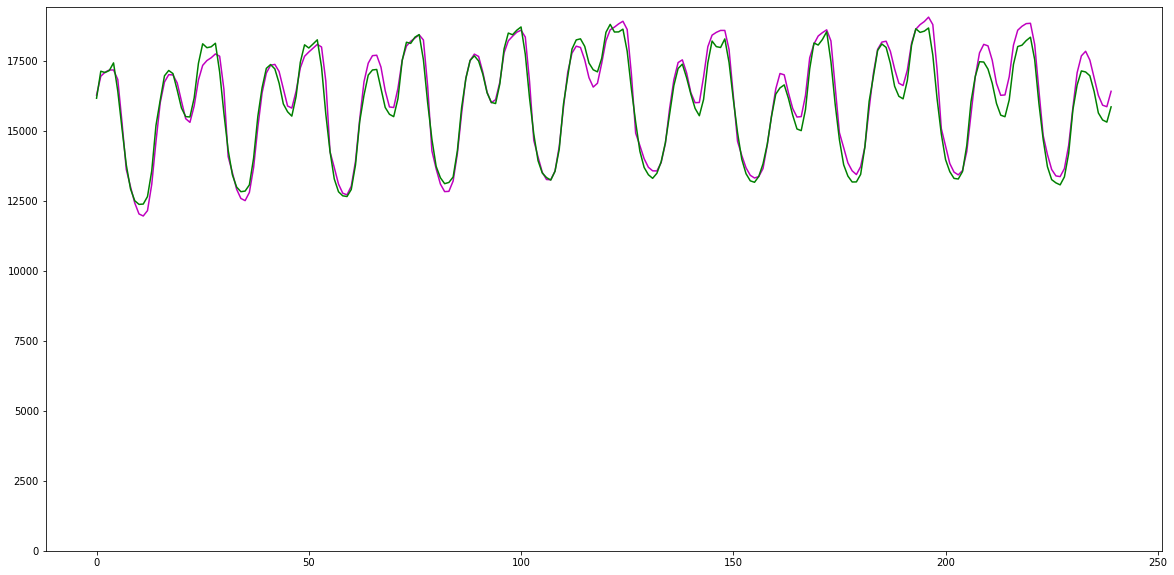

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(load_pred[:240, 23], 'm')
plt.plot(load_true[:240, 23], 'g')
plt.ylim(0)